# Random Graph Models

### This tutorial will introduce the following random graph models: 
- Erdos-Reyni (ER)
- Degree-corrected Erdos-Reyni (DCER)
- Stochastic block model (SBM)
- Degree-corrected stochastic block model (DCSBM)
- Random dot product graph (RDPG)

## Load some data from _graspologic_

For this example we will use the _Drosophila melanogaster_ larva right mushroom body connectome from [Eichler et al. 2017](https://www.ncbi.nlm.nih.gov/pubmed/28796202). Here we will consider a binarized and directed version of the graph.

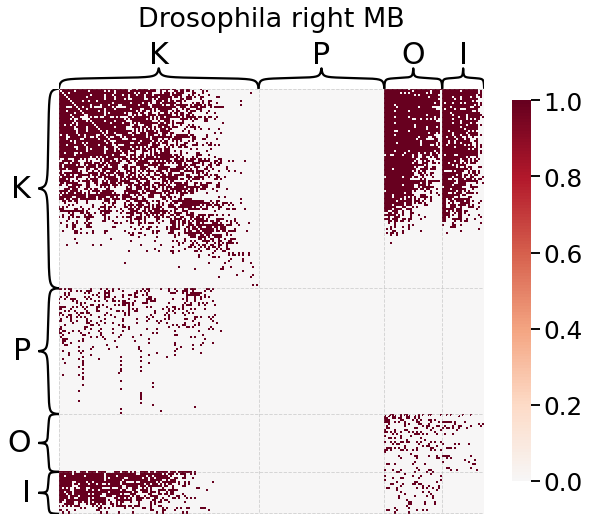

In [1]:
import numpy as np 
from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
%matplotlib inline

adj, labels = load_drosophila_right(return_labels=True)
adj = binarize(adj)
_ = heatmap(adj,
        inner_hier_labels=labels,
        title='Drosophila right MB',
        font_scale=1.5,
        sort_nodes=True)

## Preliminaries

$n$ - the number of nodes in the graph

$A$ - $n \times n$ adjacency matrix

$P$ - $n \times n$ matrix of probabilities


For the class of models we will consider here, a graph (adjacency matrix) $A$ is sampled as follows:

$$A \sim Bernoulli(P)$$

While each model we will discuss follows this formulation, they differ in how the matrix $P$ is constructed. So, for each model, we will consider how to model $P_{ij}$, or the probability of connection between any node $i$ and $j$, with $i \neq j$ in this case (i.e. no "loops" are allowed for the sake of this tutorial).


------


### For each graph model we will show: 
- how the model is formulated 
- how to fit the model using graspologic
- the P matrix that was fit by the model 
- a single sample from the fit model

## Erdos-Reyni (ER)
The Erdos-Reyni (ER) model is the simplest random graph model. We are interested in modeling the probability of an edge existing between any two nodes, $i$ and $j$. We denote this probability $P_{ij}$. For the ER model:

$$P_{ij} = p$$

for any combination of $i$ and $j$.  
This means that the one parameter $p$ is the overall probability of connection for any two nodes. 

ER "p" parameter: 0.1661046088739007


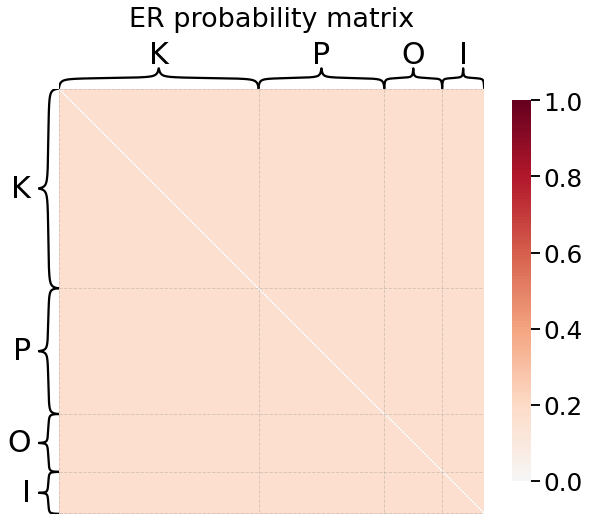

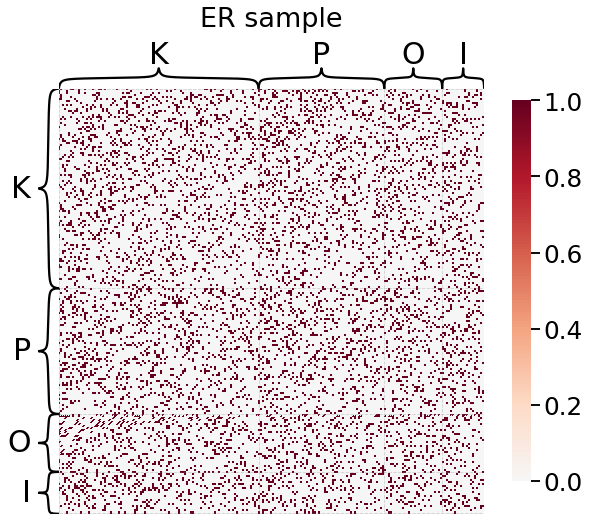

In [2]:
from graspologic.models import EREstimator
er = EREstimator(directed=True,loops=False)
er.fit(adj)
print(f"ER \"p\" parameter: {er.p_}")
heatmap(er.p_mat_,
        inner_hier_labels=labels,
        font_scale=1.5,
        title="ER probability matrix",
        vmin=0, vmax=1, 
        sort_nodes=True)
_ = heatmap(er.sample()[0],
        inner_hier_labels=labels,
        font_scale=1.5,
        title="ER sample",
        sort_nodes=True)

## Degree-corrected Erdos-Reyni (DCER)

A slightly more complicated variant of the ER model is the degree-corrected Erdos-Reyni model (DCER). Here, there is still a global parameter $p$ to specify relative connection probability between all edges. However, we add a promiscuity parameter $\theta_i$ for each node $i$ which specifies its expected degree relative to other nodes:

$$P_{ij} = \theta_i \theta_j p$$

so the probability of an edge from $i$ to $j$ is a function of the two nodes' degree-correction parameters, and the overall probability of an edge in the graph. 

DCER "p" parameter: 7536.0


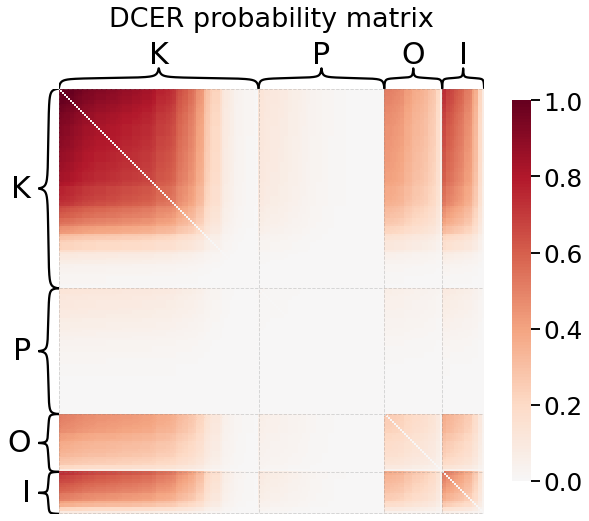

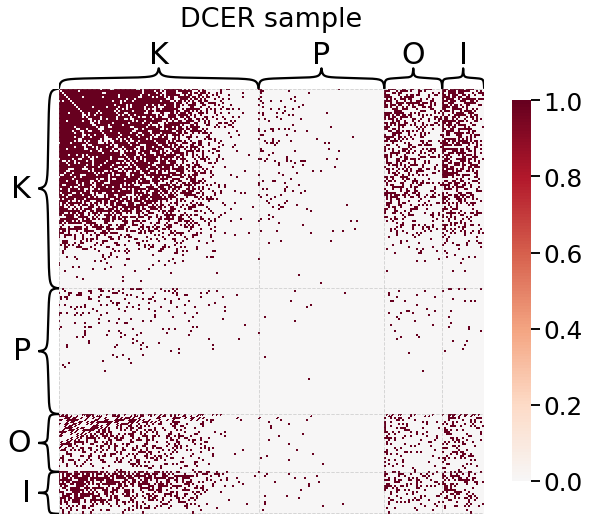

In [3]:
from graspologic.models import DCEREstimator
dcer = DCEREstimator(directed=True,loops=False)
dcer.fit(adj)
print(f"DCER \"p\" parameter: {dcer.p_}")
heatmap(dcer.p_mat_,
        inner_hier_labels=labels,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="DCER probability matrix", 
        sort_nodes=True);
_ = heatmap(dcer.sample()[0],
        inner_hier_labels=labels,
        font_scale=1.5,
        title="DCER sample", 
        sort_nodes=True)

## Stochastic block model (SBM)
Under the stochastic block model (SBM), each node is modeled as belonging to a block (sometimes called a community or group). The probability of node $i$ connecting to node $j$ is simply a function of the block membership of the two nodes. Let $n$ be the number of nodes in the graph, then $\tau$ is a length $n$ vector which indicates the block membership of each node in the graph. Let $K$ be the number of blocks, then $B$ is a $K \times K$ matrix of block-block connection probabilities. 

$$P_{ij} = B_{\tau_i \tau_j}$$

SBM "B" matrix:
[[0.         0.38333333 0.11986864 0.        ]
 [0.44571429 0.3584     0.49448276 0.        ]
 [0.09359606 0.         0.20095125 0.        ]
 [0.         0.07587302 0.         0.        ]]


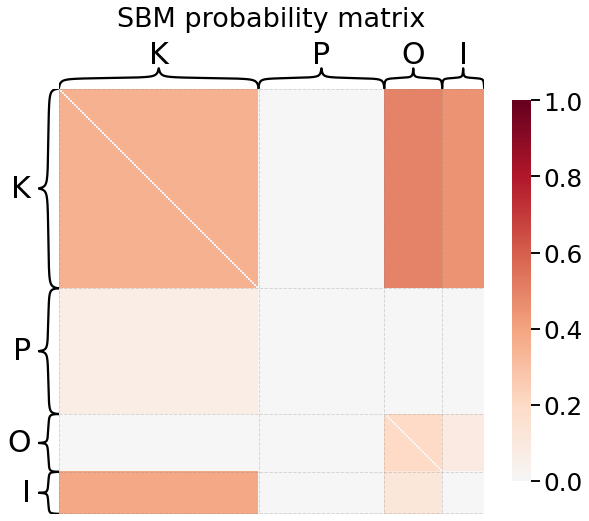

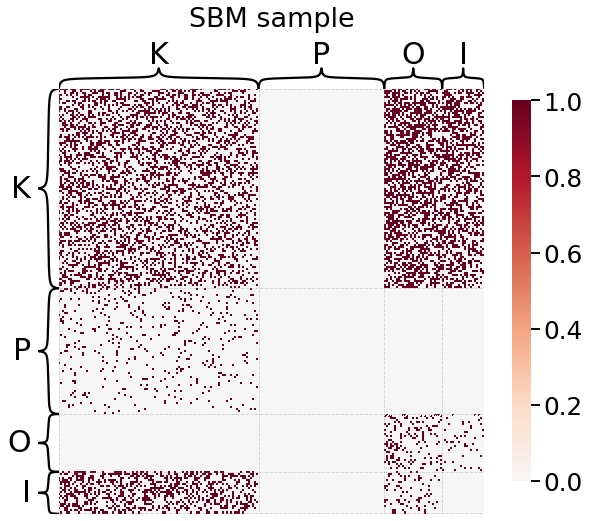

In [4]:
from graspologic.models import SBMEstimator
sbme = SBMEstimator(directed=True,loops=False)
sbme.fit(adj, y=labels)
print("SBM \"B\" matrix:")
print(sbme.block_p_)
heatmap(sbme.p_mat_,
        inner_hier_labels=labels,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="SBM probability matrix", 
        sort_nodes=True)
_ = heatmap(sbme.sample()[0],
        inner_hier_labels=labels,
        font_scale=1.5,
        title="SBM sample", 
        sort_nodes=True)

## Degree-corrected stochastic block model (DCSBM)
Just as we could add a degree-correction term to the ER model, so too can we modify the stochastic block model to allow for heterogeneous expected degrees. Again, we let $\theta$ be a length $n$ vector of degree correction parameters, and all other parameters remain as they were defined above for the SBM: 

$$P_{ij} = \theta_i \theta_j B_{\tau_i, \tau_j}$$

Note that the matrix $B$ may no longer represent true probabilities, because the addition of the $\theta$ vectors introduces a multiplicative constant that can be absorbed into the elements of $\theta$.

DCSBM "B" matrix:
[[   0.  805.   73.    0.]
 [ 936. 3584. 1434.    0.]
 [  57.    0.  169.    0.]
 [   0.  478.    0.    0.]]


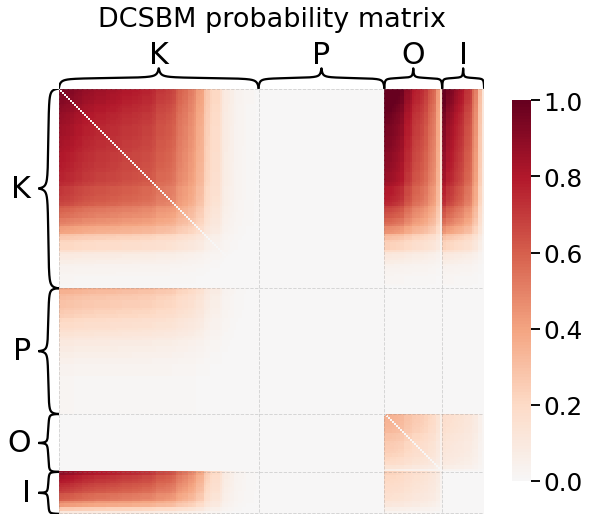

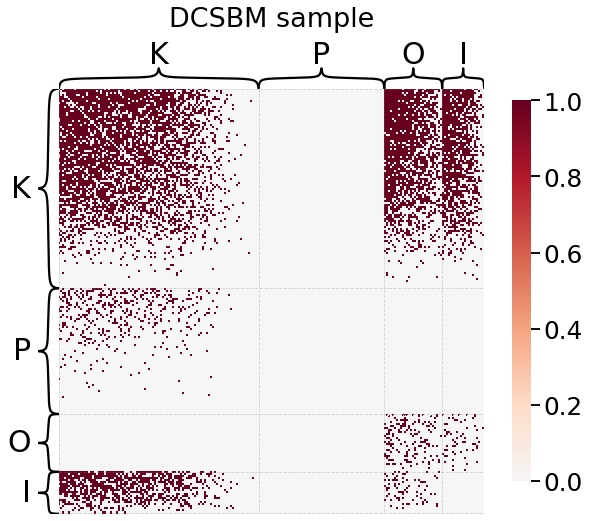

In [5]:
from graspologic.models import DCSBMEstimator
dcsbme = DCSBMEstimator(directed=True,loops=False)
dcsbme.fit(adj, y=labels)
print("DCSBM \"B\" matrix:")
print(dcsbme.block_p_)
heatmap(dcsbme.p_mat_,
        inner_hier_labels=labels,
        font_scale=1.5, 
        title="DCSBM probability matrix",
        vmin=0,
        vmax=1,
        sort_nodes=True)
_ = heatmap(dcsbme.sample()[0],
        inner_hier_labels=labels,
        title="DCSBM sample",
        font_scale=1.5,
        sort_nodes=True)

## Random dot product graph (RDPG)

Under the random dot product graph model, each node is assumed to have a "latent position" in some $d$-dimensional Euclidian space. This vector dictates that node's probability of connection to other nodes. For a given pair of nodes $i$ and $j$, the probability of connection is the dot product between their latent positions. If $x_i$ and $x_j$ are the latent positions of nodes $i$ and $j$, respectively:

$$P_{ij} = \langle x_i, x_j \rangle$$



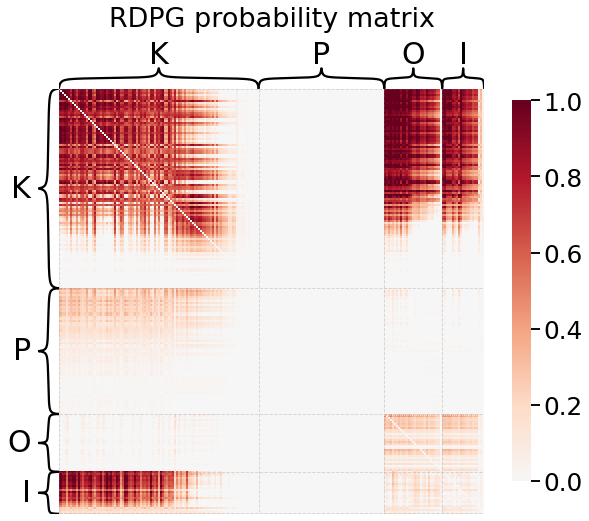

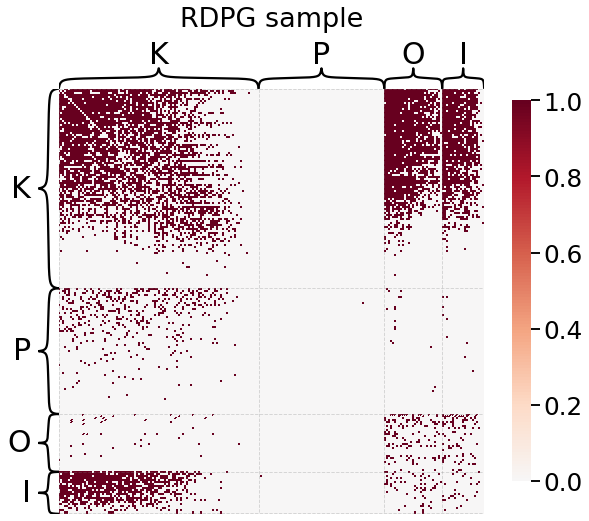

In [6]:
from graspologic.models import RDPGEstimator
rdpge = RDPGEstimator(loops=False)
rdpge.fit(adj, y=labels)
heatmap(rdpge.p_mat_,
        inner_hier_labels=labels,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="RDPG probability matrix",
        sort_nodes=True
       )
_ = heatmap(rdpge.sample()[0],
        inner_hier_labels=labels,
        font_scale=1.5,
        title="RDPG sample",
        sort_nodes=True)

## Create a figure combining all of the models

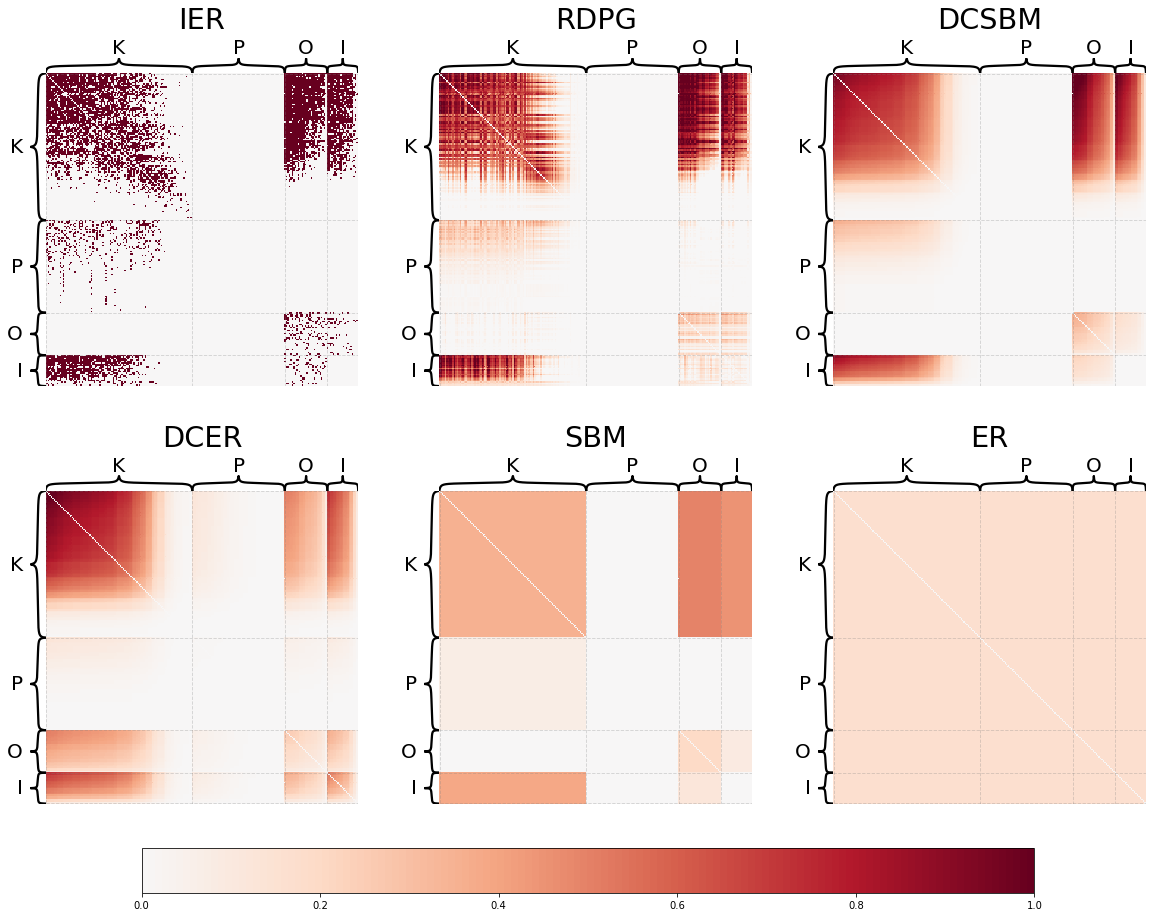

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

fig, axs = plt.subplots(2, 3, figsize=(20, 16))

# colormapping
cmap = cm.get_cmap("RdBu_r")

center = 0
vmin = 0
vmax = 1
norm = mpl.colors.Normalize(0, 1)
cc = np.linspace(0.5, 1, 256) 
cmap = mpl.colors.ListedColormap(cmap(cc))

# heatmapping
heatmap_kws = dict(
    inner_hier_labels=labels,
    vmin=0,
    vmax=1,
    cbar=False,
    cmap=cmap,
    center=None,
    hier_label_fontsize=20,
    title_pad=45,
    font_scale=1.6,
    sort_nodes=True
)

models = [rdpge, dcsbme, dcer, sbme, er]
model_names = ["RDPG", "DCSBM","DCER", "SBM", "ER"]

heatmap(adj, ax=axs[0][0], title="IER", **heatmap_kws)
heatmap(models[0].p_mat_, ax=axs[0][1], title=model_names[0], **heatmap_kws)
heatmap(models[1].p_mat_, ax=axs[0][2], title=model_names[1], **heatmap_kws)
heatmap(models[2].p_mat_, ax=axs[1][0], title=model_names[2], **heatmap_kws)
heatmap(models[3].p_mat_, ax=axs[1][1], title=model_names[3], **heatmap_kws)
heatmap(models[4].p_mat_, ax=axs[1][2], title=model_names[4], **heatmap_kws)


# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(dcsbme.p_mat_)
_ = fig.colorbar(sm,
             ax=axs,
             orientation="horizontal",
             pad=0.04,
             shrink=0.8,
             fraction=0.08,
             drawedges=False)